In [1]:
from sklearn.decomposition import PCA

In [2]:
import tensorflow as tf

2024-03-28 13:37:23.021904: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 13:37:23.493432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from tensorflow.keras.models import load_model

In [1]:
import numpy as np

In [5]:
model = load_model('surogate.h5')

2024-03-28 13:37:25.034060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9604 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2024-03-28 13:37:25.034582: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


In [6]:
num_nodes = 1000000

In [7]:
# 物理边界
mmin = np.array([1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4])
mmax = np.array([5, 5, 5, 5, 5, 5, 5, 5, 100, 100, 100, 100])

In [8]:
geom = np.random.uniform(mmin, mmax, (num_nodes, 12))
freq1 = np.ones((num_nodes, 1), dtype=np.float32) * 2.4
freq2 = np.ones((num_nodes, 1), dtype=np.float32) * 2.5
freq3 = np.ones((num_nodes, 1), dtype=np.float32) * 2.6

In [9]:
# 特定频率
def loss_freq(s_para):
    # 能量
    E = np.square(s_para)
    E11 = E[:,0] + E[:,1]
    E21 = E[:,2] + E[:,3]
    E31 = E[:,4] + E[:,5]
    E41 = E[:,6] + E[:,7]

    # 压制
    loss1 = E11 - E21 - E31 + E41
    # 比例
    loss2 = np.abs(E21 / (E31 + E21) - 0.7)
    # phase
    loss3 = np.abs(np.arctan2(s_para[:,3], s_para[:,2]) - np.arctan2(s_para[:,5], s_para[:,4]) - np.pi / 4)
    # 能量守恒
    loss4 = np.abs(np.sum(E, axis=1) - 1)
    
    return loss1 + loss2 + loss3 + loss4

In [10]:
def dgn_obj(s1, s2, s3):
    # return tf.reduce_max([loss_freq(s1), loss_freq(s2), loss_freq(s3)], axis=0)
    return loss_freq(s1) + loss_freq(s2) + loss_freq(s3)

In [11]:
y_pred1 = model.predict(np.concatenate((freq1, geom), axis=-1), batch_size=10000, verbose=0)
y_pred2 = model.predict(np.concatenate((freq2, geom), axis=-1), batch_size=10000, verbose=0)
y_pred3 = model.predict(np.concatenate((freq3, geom), axis=-1), batch_size=10000, verbose=0)
loss = dgn_obj(y_pred1, y_pred2, y_pred3)

In [12]:
pca = PCA(n_components=2)

In [13]:
geom2d = pca.fit_transform(geom)

In [19]:
xyz = np.concatenate([geom2d, loss.reshape(-1,1)], axis=-1)

In [23]:
import pandas as pd
df = pd.DataFrame(xyz)

In [ ]:
df.to_csv('contourLine.csv', index=False)

In [3]:
AS_dataset = pd.read_csv('./../Arbitrary_Single_band_Coupler_Phase_Shift.csv', encoding='utf-8')
full_X = AS_dataset.loc[:,'freq':'L4'].to_numpy(dtype = np.float32)
full_y = AS_dataset.loc[:,'S11r':'S41i'].to_numpy(dtype = np.float32)

In [47]:
geomDS = full_X[:30000, 1:]

In [38]:
spDS1 = full_y[:30000]
spDS2 = full_y[30000:60000]
spDS3 = full_y[60000:]

In [52]:
lossDS = dgn_obj(spDS1, spDS2, spDS3)

In [53]:
pca = PCA(n_components=2)

In [54]:
geom2dDS = pca.fit_transform(geomDS)

In [57]:
xyzDS = np.concatenate([geom2dDS, lossDS.reshape(-1,1)], axis=-1)

In [59]:
dfDS = pd.DataFrame(xyzDS)

In [60]:
dfDS.to_csv('contourLineDS.csv', index=False)

In [72]:
xyzDS2 = np.concatenate([geomDS, lossDS.reshape(-1,1)], axis=-1)

In [74]:
dfDS2 = pd.DataFrame(xyzDS2)

In [75]:
dfDS2.to_csv('contourLineDS2.csv', index=False)

In [102]:
geom_1 = np.random.uniform(mmin[10:], mmax[10:], (100000, 2))

In [103]:
geom_2 = np.array([[3.44724455,  4.14013981,  1.47784882,  4.72966386,  4.0446644,   1.72812159,  3.18981245,  3.37078851, 55.18916198, 63.89162806]])

In [104]:
geom_2 = geom_2.repeat(100000, axis=0)

In [105]:
geom_3 = np.concatenate([geom_2, geom_1], axis=-1)

In [107]:
y_pred1 = model.predict(np.concatenate((freq1[:100000], geom_3), axis=-1), batch_size=10000, verbose=0)
y_pred2 = model.predict(np.concatenate((freq2[:100000], geom_3), axis=-1), batch_size=10000, verbose=0)
y_pred3 = model.predict(np.concatenate((freq3[:100000], geom_3), axis=-1), batch_size=10000, verbose=0)
loss_3 = dgn_obj(y_pred1, y_pred2, y_pred3)

In [108]:
xyz3 = np.concatenate([geom_3, loss_3.reshape(-1,1)], axis=-1)

In [109]:
df3 = pd.DataFrame(xyz3)

In [110]:
df3.to_csv('contourLine3.csv', index=False)

In [111]:
import matplotlib.pyplot as plt

TypeError: Input z must be 2D, not 1D

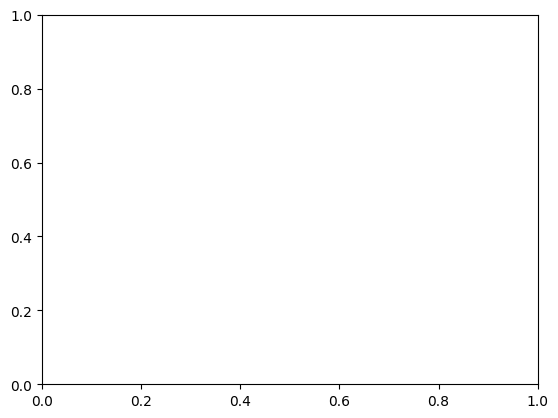

In [115]:
plt.contourf(geom_1[:,0], geom_2[:,1], loss_3,  20, cmap='RdGy')